### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import itertools
from tqdm import tqdm

import statsmodels.api as sm
from scipy.stats import t, f, boxcox, skew, kurtosis, gmean
from statsmodels.stats.diagnostic import linear_reset, het_white

import warnings
warnings.filterwarnings('ignore')

### Обработка

In [2]:
data = pd.read_csv('data_after_feature_selection.csv', encoding='utf-8')

### Логарифм цены

In [3]:
data['log_price'] = np.log(data['price'])
data = data.drop(['price'], axis=1)
y = data['log_price']
X = data.drop(['log_price'], axis=1)

### Регрессоры, которые можно логарифмировать и нет

In [4]:
cols_to_try_log = ['avg_rating', 'tirage', 'cnt_reviews', 'pages_cnt']
unconditional_cols = [x for x in X.columns.tolist() if x not in cols_to_try_log]

In [5]:
def generate_all_combinations(num_of_repeats):
    """Генерирует все комбинации признаков, к которым применяется функциональное преобразование"""
    return product([False, True], repeat=num_of_repeats)

def prepare_X(cols_to_try_func, combination, df, func, flag='stay'):
    """Создает матрицу X для текущей комбинации"""
    """Примеры функций: np.log, np.power, np.reciprocal, ..."""
    X_temp = df[unconditional_cols].copy()
    feature_name = getattr(func, '__name__', repr(func))
    
    for i, col in enumerate(cols_to_try_func): # col = 'tirage'
        if combination[i]:
            try:
                safe_col = df[col]
                if (safe_col <= 0).any() and (func == np.log) or (func == np.reciprocal):
                    safe_col = safe_col + 1e-6
                if flag == 'stay':
                    X_temp[col] = safe_col
                    X_temp[f'{feature_name}_{col}'] = func(safe_col)
                else:
                    X_temp[f'{feature_name}_{col}'] = func(safe_col)
            except Exception as e:
                print(f"Ошибка при применении функции к {col}: {e}")
        else:
            X_temp[col] = df[col]
    
    return sm.add_constant(X_temp)

def getting_statistic(cols_to_try_func, df, func, flag='stay'):
    results = []

    total_combinations = 2 ** len(cols_to_try_func)
    feature_name = getattr(func, '__name__', repr(func))

    for combination in tqdm(generate_all_combinations(num_of_repeats=len(cols_to_try_func)), total=total_combinations):
        try:
            # Подготавливаем данные
            X_curr = prepare_X(cols_to_try_func, combination, df, func, flag=flag)

            model = sm.OLS(df['log_price'], X_curr).fit()
            results.append({
                'combination': combination,
                'aic': model.aic,
                'bic': model.bic,
                'adj_r2': model.rsquared_adj,
            })

        except Exception as e:
            print(f"Error in combination {combination}: {str(e)}")
            continue

    df_results = pd.DataFrame(results)

    df_results[f'{feature_name}_columns'] = df_results['combination'].apply(
        lambda x: [cols_to_try_func[i] for i, my_func in enumerate(x) if my_func]
    )
    
    return df_results

In [6]:
def custom_func(x):
    return x**2

In [7]:
my_func = np.log
data_frame = getting_statistic(cols_to_try_func=cols_to_try_log, df=data, func=my_func, flag='')

best_aic = data_frame.loc[data_frame['aic'].idxmin()]
best_bic = data_frame.loc[data_frame['bic'].idxmin()]
best_adj_r2 = data_frame.loc[data_frame['adj_r2'].idxmax()]

print("Лучшая модель по AIC:")
print(f"Логарифмированные переменные: {best_aic[f'{my_func.__name__}_columns']}")
print(f"AIC: {best_aic['aic']:.2f}\n")

print("Лучшая модель по BIC:")
print(f"Логарифмированные переменные: {best_bic[f'{my_func.__name__}_columns']}")
print(f"BIC: {best_bic['bic']:.2f}\n")

print("Лучшая модель по Adj.R²:")
print(f"Логарифмированные переменные: {best_adj_r2[f'{my_func.__name__}_columns']}")
print(f"Adj.R²: {best_adj_r2['adj_r2']:.4f}")

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 149.32it/s]

Лучшая модель по AIC:
Логарифмированные переменные: ['tirage']
AIC: 1702.39

Лучшая модель по BIC:
Логарифмированные переменные: ['tirage']
BIC: 1781.27

Лучшая модель по Adj.R²:
Логарифмированные переменные: ['tirage']
Adj.R²: 0.6062


**Вывод:** нужно логарифмировать тираж; Adj R^2 = 0.6062

**Логарифмирование тиража:**

In [8]:
upd_data = data.copy()
upd_data['log_tirage'] = np.log(upd_data['tirage'])
upd_data = upd_data.drop(['tirage'], axis=1)
upd_data.head()

,const,avg_rating,cnt_reviews,pages_cnt,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Мягкий_переплёт,2024_or_2025,6-,16+,log_price,log_tirage
0,1.0,4.1,925,512,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,5.743003,10.308953
1,1.0,4.1,1341,320,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,5.743003,10.308953
2,1.0,4.5,363,192,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,5.648974,10.126631
3,1.0,4.3,872,288,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,5.826000,9.392662
4,1.0,4.2,3004,320,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,5.648974,10.308953


In [9]:
X_upd = upd_data.drop(['log_price'], axis=1)

In [10]:
# cols_to_try_log_ = ['avg_rating', 'cnt_reviews', 'pages_cnt']
# unconditional_cols_ = [x for x in X_try.columns.tolist() if x not in cols_to_try_log_]

Также функции будут работать, если мы решим проверить какие-то кастомные функции типо этого:

### Итоговая модель с ln Y

После проверки всех функциональных форм обучаем итоговую модель:

In [11]:
log_model = sm.OLS(data['log_price'], X_upd).fit()
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     410.2
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        12:23:18   Log-Likelihood:                -838.20
No. Observations:                3190   AIC:                             1702.
Df Residuals:                    3177   BIC:                             1781.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

# Тест Рамсея и далее

In [12]:
reset_result = linear_reset(log_model, power=2)

print("RESET test (Ramsey)")
print(reset_result)

RESET test (Ramsey)
<Wald test (chi2): statistic=108.30227439059442, p-value=2.3075960369913895e-25, df_denom=1>


**Вывод:** отвергаем H0 ==> нужно добавить степени

In [13]:
X_ramsey = X_upd.copy()
X_ramsey['Y_hat^2'] = log_model.fittedvalues**2
X_ramsey['Y_hat^3'] = log_model.fittedvalues**3
X_ramsey['Y_hat^4'] = log_model.fittedvalues**4
X_ramsey['Y_hat^5'] = log_model.fittedvalues**5

In [14]:
log_model = sm.OLS(data['log_price'], X_ramsey).fit()
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     350.3
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        12:23:18   Log-Likelihood:                -707.73
No. Observations:                3190   AIC:                             1449.
Df Residuals:                    3173   BIC:                             1553.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [15]:
reset_result = linear_reset(log_model, power=3)

print("RESET test (Ramsey)")
print(reset_result)

RESET test (Ramsey)
<Wald test (chi2): statistic=0.6025292253458937, p-value=0.7398819646968608, df_denom=2>


In [16]:
# Тест Уайта
residuals = log_model.resid
white_test = het_white(residuals, X_upd)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

LM-статистика: 737.9053713169329
p-value для LM-статистики: 1.4004457286219903e-110
F-статистика: 12.845116116140936
p-value для F-статистики: 1.5175645130989448e-128
Гетероскедастичность выявлена.


In [17]:
# Тест Глейзера
abs_residuals = np.abs(residuals)
glejser_model = sm.OLS(abs_residuals, X_upd).fit()

p_values = glejser_model.pvalues
# print(f"P-значения:")
# if p_values[0]:
#     print(p_values)
if any(p < 0.05 for p in p_values[1:]):
    print("Есть признаки гетероскедастичности.")
else:
    print("Нет признаков гетероскедастичности.")

Есть признаки гетероскедастичности.


## Попытки убрать гетероскедастичность:

## 1) Реализация WLS:

In [18]:
log_model = sm.OLS(data['log_price'], X_upd).fit()

resid = log_model.resid
y_pred = log_model.fittedvalues

In [19]:
# вспомогательная модель, записанная через модуль - не помогла
aux_model_1 = sm.OLS(np.abs(resid), sm.add_constant(y_pred)).fit()
sigma_hat_1 = aux_model_1.fittedvalues
weights_1 = 1 / sigma_hat_1

In [20]:
# тогда попробуем вспомогательную модель, записанную через квадрат
aux_model_2 = sm.OLS(resid ** 2, sm.add_constant(y_pred)).fit()
sigma_hat_2 = aux_model_2.fittedvalues
weights_2 = 1 / np.sqrt(sigma_hat_2)

In [23]:
y_new = data['log_price'] / sigma_hat_2

quantitative_feature = ['avg_rating', 'log_tirage', 'cnt_reviews', 'pages_cnt']

X_upd[quantitative_feature] = X_upd[quantitative_feature].div(sigma_hat_2, axis=0)
wls_like_model = sm.WLS(y_new, X_upd, weights=weights_2).fit() # надо изменить weights на weights_1 / weights_2

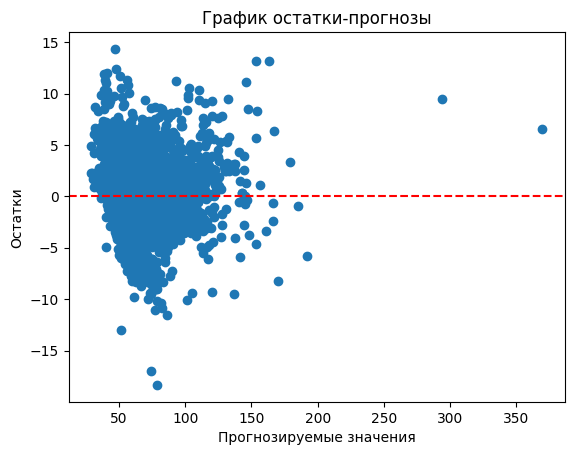

In [24]:
# Визуальный анализ (для обоих вспомогательных моделей что-то не то получается)
wls_residuals = wls_like_model.resid
fitted_values_ln_y = wls_like_model.fittedvalues

plt.scatter(fitted_values_ln_y, wls_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('График остатки-прогнозы')
plt.show()

## 2) Имплементация робастных ошибок в форме Уайта:

* `HC0` — классический White

* `HC1` — скорректированный White (умножается на n/(n−k))

* `HC2`, `HC3` — ещё более устойчивые, особенно при небольших выборках

In [25]:
log_model_robust = sm.OLS(data['log_price'], X_upd).fit(cov_type='HC2')

print(log_model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     691.7
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        12:23:48   Log-Likelihood:                -1088.9
No. Observations:                3190   AIC:                             2204.
Df Residuals:                    3177   BIC:                             2283.
Df Model:                          12                                         
Covariance Type:                  HC2                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               